# Aral Sea

In this paper we will estimate the decrease of the Aral Sea surface area (shared ́between Kazakstan in the north and Uzbekistan in the south), based on the satellite coverage in 1973 and 1987 (data USGS). 

The objective is to develop scripts to implement a system based on different machine learning approaches. This system will aim at estimating on each image the surface of the Aral Sea and its decrease over time. These scripts will thus have to follow the general chain :

* preprocessing
* features extraction
* learning a classification model
* pixel classification.

## Data review, preprocessing and features extraction

First we need to load some usefull modules for this exercice.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Images loading

The next step is to load the provided images with the _loadImages_ module.

In [59]:
from loadImages import loadImages

# Loading images
img73, img87 = loadImages()

We are now able to show these images.

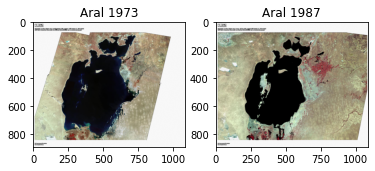

In [61]:
def show_aral(img73, img87):
    # Showing these images
    plt.subplot(121)
    plt.title("Aral 1973")
    plt.imshow(img73)

    plt.subplot(122)
    plt.title("Aral 1987")
    plt.imshow(img87)

    plt.show()

show_aral(img73, img87)

## 2 Images analysing

Each image has a depth of 3, which corresponds to the intensity of the light according to the three main channels (Red, Green and Blue).

## 3 Dimension of the features space

We need to know the shape of these images in order to know the number of features we own.

In [63]:
print("Aral 73 : shape {}".format(img73.shape))
print("Aral 87 : shape {}".format(img87.shape))
s = img73.shape
print("Total features available for each images : {}".format(s[0]*s[1]*s[2]))

Aral 73 : shape (889, 1086, 3)
Aral 87 : shape (889, 1086, 3)
Total features available for each images : 2896362


There is 889 rows, 1086 colums and 3 colors for each images. It makes a total of 2.896.362 features available for each image.

## 4 Image slicing

In order to remove the displayed text at the top and the bottom of these images, we need to slice them.

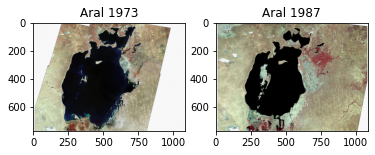

In [65]:
def slice(img, upper_index, lower_index):
    img = img[upper_index:lower_index]
    return img

upper_index, lower_index = 70, 840
img73_sliced = slice(img73, upper_index, lower_index)
img87_sliced = slice(img87, upper_index, lower_index)

show_aral(img73_sliced, img87_sliced)

## 5 Development of a learning data set

Using the _selectFeatureVector_ module we are able to sub-sample these images with a given number of points. Here we want to take one pixel out of 500 of the image *img73_sliced*.

In [67]:
from selectFeatureVectors import selectFeatureVectors

# Getting features
featLearn = selectFeatureVectors(img73_sliced, 500)

# Showing features
print("Number of features : {} x {} = {}".format(featLearn[1], featLearn[2], featLearn[1]*featLearn[2]))
print("Features : \n {}".format(featLearn[0]))

Number of features : 1673 x 3 = 5019
Features : 
 [[247. 247. 247.]
 [248. 249. 251.]
 [249. 249. 249.]
 ...
 [249. 249. 249.]
 [255. 245. 237.]
 [247. 247. 247.]]


Here we have 5019 features of our image.

## 6 First data analysis

Using _displayFeatures2d_ and _displayFeatures3d_ modules we are able to represent the features.

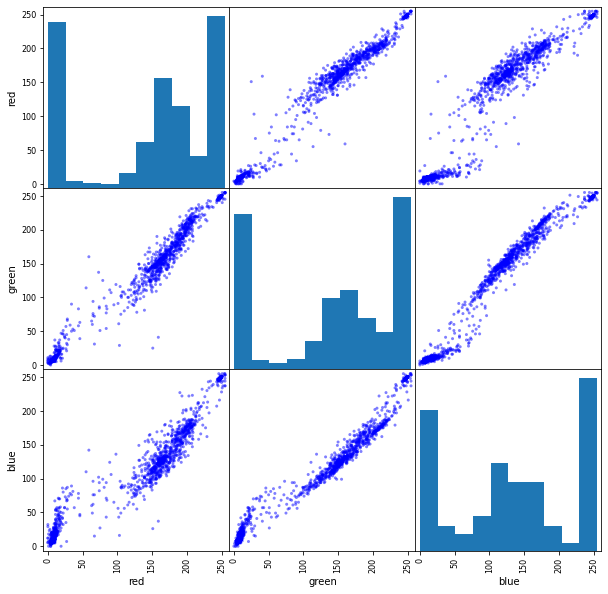

In [69]:
from displayFeatures2d import displayFeatures2d
from displayFeatures3d import displayFeatures3d

axes = displayFeatures2d(featLearn[0])

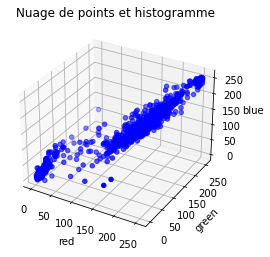

In [71]:
axes = displayFeatures3d(featLearn[0])

These two below diagram show let us analyse the features. They gave us a way to visualize any trends in our data.

**2D features diagram :**
* On the diagonal the number of pixel in the image for each pixel value in $[0, 255]$. We are able to retriev for example the white pixels which are around the picture with the approximatively 250 pixel at the value 255 for each channel (RGB). On the opposite we also see the number of dark pixels with approximately 200 pixels for each channel around the value 0, which certainly corresponds to the Aral Sea.
* For each other plot, we have for each pixel the value of the X channel for the Y channel for X and Y in ${R, G, B}$. We can see on these plot that globally we could draw two lines: one for the high pixel values corresponding certainly to the sand surrounding the sea, and one for the low pixel values corresponding certainly to the sea. These lines do not have the same slopes, and it would seem possible to characterize the color of the sea by this slope for the pixels of low luminosity.

## Part 1 : Unsupervised approach using the k-means method

### 1.1 K-means method

K-means partitioning is a way of partitioning a dataset into k groups. The goal is to determine the barycenter of each group and the cost function to be minimized is the quadratic distance to these barycenters.

### 1.2 K-means model implementing using Scikit-Learn

To setup this model we could use the python _sklearn_ module which is a powerfull machine learning library. We first need to import some functions from it.

In [73]:
from sklearn.cluster import KMeans

Then we could create our model. The important parameter is the number of cluster we want to have for this fetures vector. Here we want to partition the set of points into two clusters, so we will set *n_clusters* at 2.

In [93]:
X = featLearn[0]
kmeans = KMeans(n_clusters=4, random_state=4242).fit(X)

### 1.4 Results visualization

We will visualize the output of the classification using the same displaying functions.

array([[<AxesSubplot:xlabel='red', ylabel='red'>,
        <AxesSubplot:xlabel='green', ylabel='red'>,
        <AxesSubplot:xlabel='blue', ylabel='red'>],
       [<AxesSubplot:xlabel='red', ylabel='green'>,
        <AxesSubplot:xlabel='green', ylabel='green'>,
        <AxesSubplot:xlabel='blue', ylabel='green'>],
       [<AxesSubplot:xlabel='red', ylabel='blue'>,
        <AxesSubplot:xlabel='green', ylabel='blue'>,
        <AxesSubplot:xlabel='blue', ylabel='blue'>]], dtype=object)

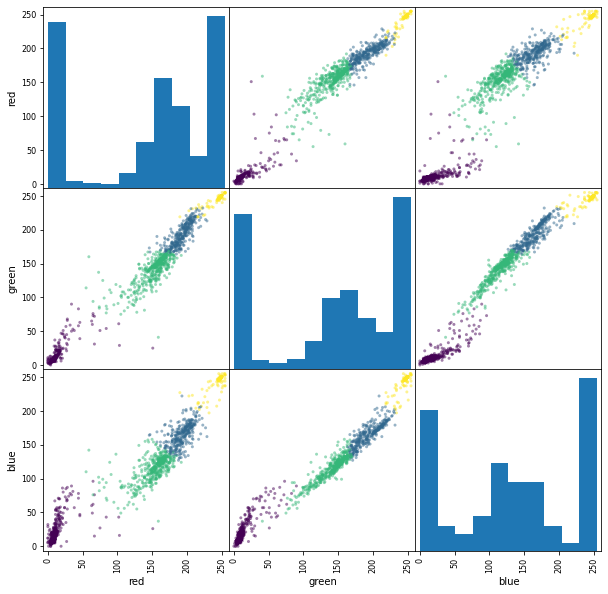

In [94]:
displayFeatures2d(X, kmeans.labels_)

<Axes3DSubplot:title={'center':'Nuage de points et histogramme'}, xlabel='red', ylabel='green'>

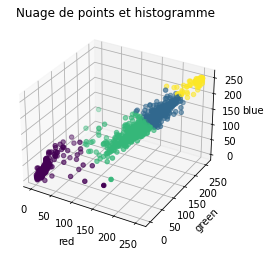

In [79]:
displayFeatures3d(X, kmeans.labels_)

The k-means classifier seems to have clustered correctly the two point clouds but there is still some purple points which seems to belong to the yellow class.

### 1.5 Classifying the input image

After the trainig of our model, we are able to test it by classifying each input pixels of our image.

In [95]:
# Getting features of the input image without sub-sampling
featLearn_73 = selectFeatureVectors(img73_sliced, 1)

# Classifying our input pixels
predict_73 = kmeans.predict(featLearn_73[0])

### 1.6 Visualizing the classified pixels

Using the _displayImageLabel_ module, we are able to display this classification on the input image. We could also classify the 1987 image using the ssame classifier.

(array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]], dtype=int32),
 <matplotlib.image.AxesImage at 0x7fd2135bb908>)

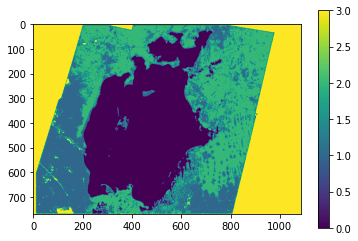

In [96]:
from displayImageLabel import displayImageLabel

displayImageLabel(predict_73, img73_sliced)

(array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]], dtype=int32),
 <matplotlib.image.AxesImage at 0x7fd25293f860>)

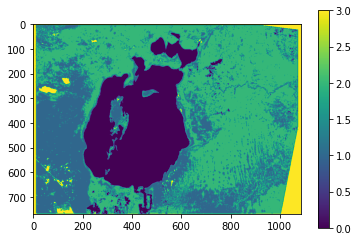

In [97]:
featLearn_87 = selectFeatureVectors(img87_sliced, 1)
predict_87 = kmeans.predict(featLearn_87[0])
displayImageLabel(predict_87, img87_sliced)

### 1.7 Aral sea area evolution estimation

We could see that the class of the sea is here the class 1. So we are able to estimate the evolution of the Aral sea area between 1973 and 1987 by assuming that the picture was shot approximatively at the same position for the two input picture.

In [98]:
# Computing the 73 ratio
area_73 = np.sum(predict_73==0)/predict_73.size

# Computing the 87 ratio
area_87 = np.sum(predict_87==0)/predict_73.size

print("1973 Aral sea area ratio : {}".format(area_73))
print("1987 Aral sea area ratio : {}".format(area_87))

# Computing evolution of the ratio
evolution_kmeans = (area_73 - area_87) / area_73
print("Reduction of the area of {:1.3f}".format(evolution_kmeans))

1973 Aral sea area ratio : 0.2789182272607687
1987 Aral sea area ratio : 0.21306593958527661
Reduction of the area of 0.236


### 1.8 Hyper parameters and accuracy

Changing the number of classes could influence the accuracy of our estimation. For example a testing the code above with 
* 2 classes give an area reduction of 14.9%
* 3 classes give an area reduction of 22.8%
* 4 classes give an area reduction of 23.6%

Increasing the number of classes seems to give more accurate resluts, but it's only a visual interpretation. For example the difference between 2 and 3 classes give a labelization more accurate of the little island visible on the 1987 image in the center of the Aral sea, which was interpreted before as sea.

## Part 2 : Unsupervised approach using GMM

### 2.1 Gaussian Mixture Model

The Gaussian Mixture Model is a model for dataset clustering assuming that the sub-populations follow a Gaussian law spatial distribution. We are then able to cluster our dataset in k classes considering this hypothesis.


In [89]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=4242).fit(X)

predict_73 = gmm.predict(featLearn_73[0])
predict_87 = gmm.predict(featLearn_87[0])

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [2, 2, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 <matplotlib.image.AxesImage at 0x7fd213544240>)

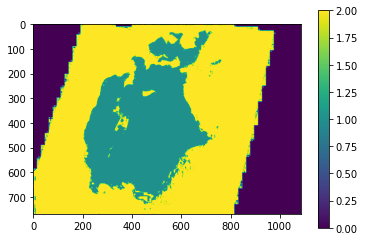

In [90]:
displayImageLabel(predict_73, img73_sliced)

(array([[2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        ...,
        [2, 2, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 <matplotlib.image.AxesImage at 0x7fd2135f57b8>)

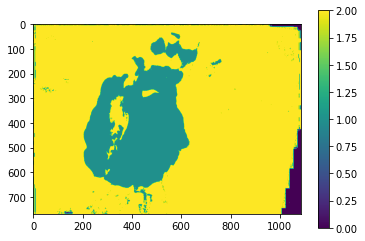

In [91]:
displayImageLabel(predict_87, img87_sliced)

In [92]:
# Computing the 73 ratio
area_73 = np.sum(predict_73==1)/predict_73.size

# Computing the 87 ratio
area_87 = np.sum(predict_87==1)/predict_73.size

print("1973 Aral sea area ratio : {}".format(area_73))
print("1987 Aral sea area ratio : {}".format(area_87))

# Computing evolution of the ratio
evolution_gmm = (area_73 - area_87) / area_73
print("Reduction of the area of {:1.3f}".format(evolution_gmm))

1973 Aral sea area ratio : 0.24371576857764704
1987 Aral sea area ratio : 0.19423716246920666
Reduction of the area of 0.203


Testing the classifier above with 
* 2 classes give an area reduction of 25.2%
* 3 classes give an area reduction of 20.4%
* 4 classes give an area reduction of 13.2%

The last result seems to not be accurate because on the 1973 image the sea is not fully classified.